You must run this notebook on a GPU. A T4 is sufficient. It's free on [Google
Colab](https://stackoverflow.com/questions/62596466/how-can-i-run-notebooks-of-a-github-project-in-google-colab/67344477#67344477).

**Description**: for a multilabel sentiment
classification task, this notebook demonstrates that zero-shot CAPPr with a [GPTQd Mistral
7B](https://huggingface.co/TheBloke/Mistral-7B-OpenOrca-GPTQ) model gets +4% F1 score over few-shot text generation with the same model (and with a modest speedup). CAPPr matches the performance of few-shot text generation with OpenAI's `gpt-3.5-turbo` model.

**Estimated run time**: ~30 min.

In [1]:
# check correct CUDA version
import torch

_cuda_version = torch.version.cuda
_msg = (
    "Change the pip install auto-gptq command to the one for "
    f"{_cuda_version} based on the list here: "
    "https://github.com/PanQiWei/AutoGPTQ#quick-installation"
)

assert _cuda_version == "12.1", _msg

In [ ]:
!python -m pip install "cappr[demos] @ git+https://github.com/kddubey/cappr.git" \
auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu121/ \
optimum

In [3]:
from __future__ import annotations
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from cappr import huggingface as hf

# Load data

ty [autolabel](https://github.com/refuel-ai/autolabel/tree/main) for a tidy version of
this dataset, and a performant prompt

In [4]:
df_tr = pd.read_csv(
    "https://autolabel-benchmarking.s3.us-west-2.amazonaws.com/twitter_emotion_detection/seed.csv"
)
df_tr = df_tr.rename(columns={"example": "text"})
len(df_tr)

200

In [5]:
df_tr.head()

,text,labels
0,“Worry is a down payment on a problem you may ...,"anticipation, optimism, trust"
1,Whatever you decide to do make sure it makes y...,"joy, love, optimism"
2,@Max_Kellerman it also helps that the majorit...,"anger, disgust, joy, optimism"
3,Accept the challenges so that you can literall...,"joy, optimism"
4,My roommate: it's okay that we can't spell bec...,"anger, disgust"


In [6]:
all_emotions_tr = df_tr["labels"].str.split(", ")
_emotions_flattened = [emotion for emotions in all_emotions_tr for emotion in emotions]

In [7]:
emotions = sorted(set(_emotions_flattened))
emotions

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'neutral',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [8]:
emotions_str = "\n".join(sorted(emotions))

In [9]:
multilabel_binarizer = MultiLabelBinarizer(classes=emotions)

In [10]:
emotions_binarized_tr = multilabel_binarizer.fit_transform(all_emotions_tr)

Curious about their distributions

In [11]:
pd.Series(_emotions_flattened).value_counts() / len(df_tr)

anger           0.440
disgust         0.410
joy             0.400
optimism        0.305
sadness         0.255
fear            0.150
love            0.130
anticipation    0.125
pessimism       0.080
trust           0.050
surprise        0.045
neutral         0.025
dtype: float64

ah right this is twitter

# Load model

In [12]:
model_name = "TheBloke/Mistral-7B-OpenOrca-GPTQ"
model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto", trust_remote_code=False, revision="main"
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

Using `disable_exllama` is deprecated and will be removed in version 4.37. Use `use_exllama` instead and specify the version with `exllama_config`.The value of `use_exllama` will be overwritten by `disable_exllama` passed in `GPTQConfig` or stored in your config file.


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
_ = model(**tokenizer(["warm up"], return_tensors="pt").to(model.device))

# CAPPr

In [14]:
chat_template_shared_instructions = """
<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{user_prompt}
""".strip("\n")

chat_template_prompt = """
{prompt}<|im_end|>
<|im_start|>assistant
""".lstrip("\n")

In [15]:
system_message = (
    "You are an expert at classifying tweets as one or more of the emotions below that "
    "best represents the mental state of the poster.\n"
    "Possible emotions:\n"
    f"{emotions_str}\n\n"
    "Your job is to correctly label the emotional sentiment of the given tweet.\n"
    "Answer with one emotion and nothing else."
)
user_prompt = (
    "Label the following tweet with an emotion which represents the mental state of "
    "the poster:"
)
prompt_prefix = chat_template_shared_instructions.format(
    system_message=system_message,
    user_prompt=user_prompt,
)

df_tr["prompt_suffix"] = [
    chat_template_prompt.format(prompt=text) for text in df_tr["text"]
]

In [16]:
# Here's what the model will see
print(prompt_prefix + " " + df_tr["prompt_suffix"].iloc[0])

<|im_start|>system
You are an expert at classifying tweets as one or more of the emotions below that best represents the mental state of the poster.
Possible emotions:
anger
anticipation
disgust
fear
joy
love
neutral
optimism
pessimism
sadness
surprise
trust

Your job is to correctly label the emotional sentiment of the given tweet.
Answer with one emotion and nothing else.<|im_end|>
<|im_start|>user
Label the following tweet with an emotion which represents the mental state of the poster: “Worry is a down payment on a problem you may never have'.  Joyce Meyer.  #motivation #leadership #worry<|im_end|>
<|im_start|>assistant



In [17]:
with hf.classify.cache((model, tokenizer), prompt_prefix) as cached:
    pred_probs_tr = hf.classify.predict_proba(
        prompts=df_tr["prompt_suffix"],
        completions=emotions,
        model_and_tokenizer=cached,
        batch_size=8,
    )

conditional log-probs:   0%|          | 0/200 [00:00<?, ?it/s]

## Convert probabilities to binarized predictions

We're trying to "tag" a tweet with anywhere from 1 to 12 (the number of possible
emotions) labels. With probabilities, an easy way to do that is to set some minimum
threshold. If a probability is greater than the threshold, tag the tweet with that
emotion.

But what threshold should we use?

If you don't have any labeled training data (you should get some), you can try setting
the threshold to `1 / # choices`.

If you do have labeled training data, you can statistically optimize the threshold by
trying out a couple thresholds along a grid. Here's a function which does that:

In [18]:
def search_thresholds(
    pred_probs: np.ndarray,
    labels_binarized: np.ndarray,
    thresholds: Sequence[float] | None = None,
    min_threshold: float | None = None,
    max_threshold: float | None = None,
    num_thresholds: int | None = None,
    plot: bool = False,
) -> float:
    """
    Grid search to maximize F1 score.
    """
    # Define grid of thresholds
    if thresholds is None:
        threshold_base = 1 / pred_probs.shape[1]
        min_threshold = min_threshold or pred_probs.min()
        max_threshold = max_threshold or 2 * threshold_base
        num_thresholds = num_thresholds or int(pred_probs.shape[0] / 10)
        thresholds = np.linspace(min_threshold, max_threshold, num=num_thresholds)

    # Search
    scores = [
        f1_score(labels_binarized, pred_probs > threshold, average="macro")
        for threshold in thresholds
    ]

    # Plot results
    metric_name = f1_score.__qualname__  # TODO: allow for other metrics
    df = pd.DataFrame(
        {"probability threshold": thresholds, metric_name: scores}
    )
    if plot:
        df.plot(x="probability threshold", y=metric_name, style=".-")
        plt.axvline(threshold_base, label="1 / # choices", color="black")
        plt.legend()

    # Best threshold on training data
    best_threshold = df["probability threshold"].iloc[
        df[metric_name].argmax()
    ]
    return best_threshold

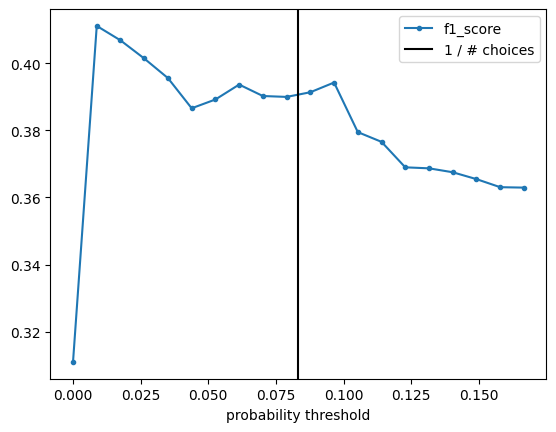

In [19]:
threshold = search_thresholds(pred_probs_tr, emotions_binarized_tr, plot=True)

In [20]:
threshold

0.008771931157937526

You can even have a threshold for each emotion. But let's keep things simple.

Baseline from random guessing (in some sense)

In [21]:
_rand_scores = np.random.uniform(size=(len(df_tr), len(emotions)))
_rand_probs = _rand_scores / _rand_scores.sum(axis=1, keepdims=True)
f1_score(emotions_binarized_tr, _rand_probs > threshold, average="macro")

0.30703026727515315

# Text generation

In [22]:
chat_template = """
<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start|>assistant
""".lstrip("\n")

In [23]:
def prompt_text_gen(text: str):
    system_message = (
        "You are an expert at classifying tweets as one or more of the emotions below "
        "that best represents the mental state of the poster.\n"
        "Possible emotions:\n"
        f"{emotions_str}\n\n"
        "Your job is to correctly label the emotions of the given tweet.\n"
        "Return the answer as a comma-separated list of labels, for example: emotion1, "
        "emotion2, emotion3\n"
        "Some examples with their expected output are provided below.\n\n"
        ""
        "Input: @MaryamNSharif I think just becz u have so much terror in pak nd "
        "urself being  a leader u forgot d difference btw a leader nd terrorist !\n"
        "Output: anger, disgust, fear\n\n"
        ""
        "Input: In wake of fresh #terror threat and sounding of alert in #Mumbai, "
        "praying for safety &amp; security of everybody in the city #Maharashtra "
        "#news\n"
        "Output: fear\n\n"
        ""
        "Input: Somewhere I rd a rpt tht Pakis wr afraid of TSD &amp; asked it 2 shut "
        "dn.  Congis obliged &amp; exposed it,hounded them.time to revive. "
        "#BadlaofUri\n"
        "Output: neutral"
    )
    prompt = (
        "Label the following tweet with emotions which represent the mental state of "
        "the poster.\n\n"
        f"Input: {text}\n"
        "Output:"
    )
    return chat_template.format(system_message=system_message, prompt=prompt)

In [24]:
df_tr["prompt_text_gen"] = [prompt_text_gen(text) for text in df_tr["text"]]

In [25]:
print(df_tr["prompt_text_gen"].iloc[0])

<|im_start|>system
You are an expert at classifying tweets as one or more of the emotions below that best represents the mental state of the poster.
Possible emotions:
anger
anticipation
disgust
fear
joy
love
neutral
optimism
pessimism
sadness
surprise
trust

Your job is to correctly label the emotions of the given tweet.
Return the answer as a comma-separated list of labels, for example: emotion1, emotion2, emotion3
Some examples with their expected output are provided below.

Input: @MaryamNSharif I think just becz u have so much terror in pak nd urself being  a leader u forgot d difference btw a leader nd terrorist !
Output: anger, disgust, fear

Input: In wake of fresh #terror threat and sounding of alert in #Mumbai, praying for safety &amp; security of everybody in the city #Maharashtra #news
Output: fear

Input: Somewhere I rd a rpt tht Pakis wr afraid of TSD &amp; asked it 2 shut dn.  Congis obliged &amp; exposed it,hounded them.time to revive. #BadlaofUri
Output: neutral<|im_en

We need to create a PyTorch Dataset to batch the inputs.

In [26]:
class TextsDataset(torch.utils.data.Dataset):
    def __init__(self, texts: list[str]):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index: int):
        return self.texts[index]

In [27]:
text_gen_dataset_tr = TextsDataset(df_tr["prompt_text_gen"].tolist())

In [28]:
max_new_tokens = len(tokenizer(emotions_str)["input_ids"]) + 10
max_new_tokens

48

In [29]:
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=max_new_tokens,
    return_full_text=False,
)
# pad to allow batching. these get masked out ofc
generator.tokenizer.pad_token_id = generator.model.config.eos_token_id

In [30]:
completions = []
for seq in tqdm(
    generator(
        text_gen_dataset_tr,
        # suppress "Setting pad_token_id..." stdout
        pad_token_id=generator.tokenizer.eos_token_id,
        batch_size=2,
    ),
    total=len(text_gen_dataset_tr),
    desc="Sampling",
):
    completions.append(seq[0]['generated_text'])

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Let's see if the model generated a list of emotions like we asked.

In [31]:
pd.Series(completions).sample(n=10)

113           anger, sadness
153     anger, disgust, fear
19          sadness, neutral
9       anger, disgust, fear
84             joy, surprise
48                 love, joy
168         sadness, neutral
154           sadness, anger
173        sadness, surprise
22                   neutral
dtype: object

Impressive, it followed the instructions quite well.

In [32]:
def process_completion(completion: str, class_names: Sequence[str]) -> np.ndarray:
    emotions_pred = [emotion.strip().lower() for emotion in completion.split(",")]
    # Just in case, remove any empty strings
    emotions_pred = [emotion for emotion in emotions_pred if emotion]
    # Remove any emotions which aren't in the given classes
    return [
        emotion for emotion in emotions_pred if emotion in class_names
    ]

In [33]:
preds_tr_text_gen = multilabel_binarizer.transform(
    [process_completion(completion, multilabel_binarizer.classes) for completion in completions]
)

In [34]:
f1_score(emotions_binarized_tr, preds_tr_text_gen, average="macro")

0.3920210274809546

# Test

It's important to do some things honorably.

<span style="font-family: Baskerville; font-size: 18px;">I solemnly swear that I
evaluated on the test set twice (once per pre-selected method), running only the
following cells in sequence once.</span>

<img src="../signature.png" alt="drawing" width="200"/>
<div style="width:200px"><hr/></div>

In [35]:
df_te = pd.read_csv(
    "https://autolabel-benchmarking.s3.us-west-2.amazonaws.com/twitter_emotion_detection/test.csv"
)
df_te = df_te.rename(columns={"example": "text"})
len(df_te)

2000

In [36]:
emotions_binarized_te = multilabel_binarizer.transform(df_te["labels"].str.split(", "))

## Text generation

In [37]:
df_te["prompt_text_gen"] = [prompt_text_gen(text) for text in df_te["text"]]

In [38]:
text_gen_dataset_te = TextsDataset(df_te["prompt_text_gen"].tolist())

In [39]:
completions_te = []
for seq in tqdm(
    generator(
        text_gen_dataset_te,
        # suppress "Setting pad_token_id..." stdout
        pad_token_id=generator.tokenizer.eos_token_id,
        batch_size=2,
    ),
    total=len(text_gen_dataset_te),
    desc="Sampling",
):
    completions_te.append(seq[0]['generated_text'])

Sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

In [40]:
preds_te_text_gen = multilabel_binarizer.transform(
    [process_completion(completion, multilabel_binarizer.classes) for completion in completions_te]
)
f1_score(emotions_binarized_te, preds_te_text_gen, average="macro")

0.41677428798534377

## CAPPr

In [41]:
df_te["prompt_suffix"] = [
    chat_template_prompt.format(prompt=text) for text in df_te["text"]
]

In [42]:
with hf.classify.cache((model, tokenizer), prompt_prefix) as cached:
    pred_probs_te = hf.classify.predict_proba(
        prompts=df_te["prompt_suffix"],
        completions=emotions,
        model_and_tokenizer=cached,
        batch_size=8,
    )

conditional log-probs:   0%|          | 0/2000 [00:00<?, ?it/s]

In [43]:
f1_score(emotions_binarized_te, pred_probs_te > threshold, average="macro")

0.46070498415970396

[`autolabel`'s few-shot
demo](https://github.com/refuel-ai/autolabel/blob/main/examples/twitter_emotion_detection/example_twitter_emotion_detection.ipynb)
using OpenAI's `gpt-3.5-turbo` reported an F1 score of 0.4507.